In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [3]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras
from keras.utils import to_categorical

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint
from itertools import chain
import spacy

In [5]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

In [6]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Primary Variables

Filepath variables

In [8]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [9]:
LOWER: bool = True
PADDING: str = "post"

# nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

Training variables

In [10]:
# INITIAL_LR: float = 2e-5
INITIAL_LR: float = 0.001

EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256
DROPOUT: float = 0.3

LOSS_FUNCTION: str = "categorical_crossentropy"
OUTPUT_ACTIVATION: str = "softmax"
NUM_LABELS: int = 2

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [11]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [12]:
NLP = spacy.load("en_core_web_sm")

def get_ner_tags(sentences: typing.List[str]) -> typing.List[str]:
  """
  Returns a list of the NER tags for a list of sentences
  """
  sentences = list(NLP.pipe(sentences))
  return [[token.ent_type_ for token in sentence] for sentence in sentences]

In [13]:
def pad_lists(lists, value, length: int):
  """
  Pads the lists with the value specified & returns this
  """
  return [(next + length * [value])[:length] for next in lists]

In [14]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [15]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [16]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [17]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [18]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().translate(str.maketrans("","",string.punctuation)) for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = np.array([" ".join(sentence) for sentence in sentences])
  return sentences


In [19]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [82]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [83]:
dev_premises_og = dev_premises
dev_hypotheses_og = dev_hypotheses

In [84]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [85]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

In [86]:
# #Removes stop words, punctuation
# train_premises = clean_sentences(sentences=train_premises)
# train_hypotheses = clean_sentences(sentences=train_hypotheses)

# dev_premises = clean_sentences(sentences=dev_premises)
# dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [87]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: The film was selected as the Canadian entry for the Best Foreign Language Film at the 71st Academy Awards.
Hypothesis: The film was selected as the Canadian entry for the Best Foreign Language Film at the 71st Academy Awards, but was not nominated.
Label: [0. 1.]


## NER Tags
Gets the NER tags for the premises & hypotheses

In [61]:
train_premises_ner = get_ner_tags(sentences=train_premises)
train_hypotheses_ner = get_ner_tags(sentences=train_hypotheses)
dev_premises_ner = get_ner_tags(sentences=dev_premises)
dev_hypotheses_ner = get_ner_tags(sentences=dev_hypotheses)

In [62]:
ner = list(set(list(chain.from_iterable([[word for word in sentence] for sentence in train_premises_ner]))))
ner_dict = {ner[i]: i for i in range(len(ner))}

NER_PAD_KEY: str = ""
ner_dict

{'': 0,
 'ORDINAL': 1,
 'PERSON': 2,
 'FAC': 3,
 'NORP': 4,
 'DATE': 5,
 'LANGUAGE': 6,
 'PERCENT': 7,
 'WORK_OF_ART': 8,
 'LOC': 9,
 'LAW': 10,
 'PRODUCT': 11,
 'EVENT': 12,
 'CARDINAL': 13,
 'GPE': 14,
 'TIME': 15,
 'ORG': 16,
 'QUANTITY': 17,
 'MONEY': 18}

In [63]:
NER_VOCAB_SIZE: int = len(ner_dict)

In [64]:
train_premises_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=train_premises_ner, value=NER_PAD_KEY, length=MAX_PREMISE_LENGTH)])
train_hypotheses_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=train_hypotheses_ner, value=NER_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])
dev_premises_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_premises_ner, value=NER_PAD_KEY, length=MAX_PREMISE_LENGTH)])
dev_hypotheses_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_hypotheses_ner, value=NER_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])

### Example

In [65]:
print(f"Sentence: {train_premises[index]}")
print(f"NER tags: {train_premises_ner[index]}")

Sentence: GAO is also authorized to inspect an agency's records to secure the required information.
NER tags: [16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## POS Tags
Gets sequences of POS tags for the premises & hypotheses

In [88]:
train_premises_pos = [nltk.word_tokenize(sentence) for sentence in train_premises]
train_premises_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in train_premises_pos]

train_hypotheses_pos = [nltk.word_tokenize(sentence) for sentence in train_hypotheses]
train_hypotheses_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in train_hypotheses_pos]

dev_premises_pos = [nltk.word_tokenize(sentence) for sentence in dev_premises]
dev_premises_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in dev_premises_pos]

dev_hypotheses_pos = [nltk.word_tokenize(sentence) for sentence in dev_hypotheses]
dev_hypotheses_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in dev_hypotheses_pos]

In [89]:
POS_PAD_KEY: str = "PAD"

pos = list(set(list(chain.from_iterable([[word for word in sentence] for sentence in train_premises_pos]))))
pos_dict = {pos[i]: (i + 1) for i in range(len(pos))}
pos_dict[POS_PAD_KEY] = 0

pos_dict

{'PDT': 1,
 'RBR': 2,
 'VBN': 3,
 'SYM': 4,
 'VBD': 5,
 'IN': 6,
 '#': 7,
 'DT': 8,
 '``': 9,
 ',': 10,
 'WRB': 11,
 'CD': 12,
 'VBZ': 13,
 'RB': 14,
 'FW': 15,
 'MD': 16,
 'JJR': 17,
 'NNPS': 18,
 'PRP': 19,
 'VBP': 20,
 'PRP$': 21,
 'VB': 22,
 'WDT': 23,
 'WP$': 24,
 'TO': 25,
 ':': 26,
 'EX': 27,
 'NNP': 28,
 'CC': 29,
 'NN': 30,
 'WP': 31,
 ')': 32,
 '$': 33,
 'LS': 34,
 'JJ': 35,
 'RP': 36,
 'VBG': 37,
 "''": 38,
 'UH': 39,
 'RBS': 40,
 'JJS': 41,
 'NNS': 42,
 '(': 43,
 '.': 44,
 'POS': 45,
 'PAD': 0}

In [93]:
POS_VOCAB_SIZE: int = len(pos_dict)
POS_VOCAB_SIZE

46

In [91]:
train_premises_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=train_premises_pos, value=POS_PAD_KEY, length=MAX_PREMISE_LENGTH)])
train_hypotheses_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=train_hypotheses_pos, value=POS_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])
dev_premises_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_premises_pos, value=POS_PAD_KEY, length=MAX_PREMISE_LENGTH)])
dev_hypotheses_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_hypotheses_pos, value=POS_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])

### Example

In [92]:
print(f"Sentence: {train_premises[index]}")
print(f"POS tags: {train_premises_pos[index]}")

Sentence: The film was selected as the Canadian entry for the Best Foreign Language Film at the 71st Academy Awards.
POS tags: [ 8 30  5  3  6  8 35 30  6  8 28 28 28 28  6  8 12 28 28 44  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Tokenize Data

In [94]:
# BERT_ID: str = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(BERT_ID)
# bert_model = BertModel.from_pretrained(BERT_ID)

BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)
bert_model = RobertaModel.from_pretrained(BERT_ID)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [96]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [97]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['<s>', 'The', 'Ġfilm', 'Ġwas', 'Ġselected', 'Ġas', 'Ġthe', 'ĠCanadian', 'Ġentry', 'Ġfor', 'Ġthe', 'ĠBest', 'ĠForeign', 'ĠLanguage', 'ĠFilm', 'Ġat', 'Ġthe', 'Ġ71', 'st', 'ĠAcademy', 'ĠAwards', '.', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0   133   822    21  3919    25     5  1563  3555    13     5  2700
  3125 22205  6026    23     5  6121   620  3536  4229     4     2     0
     0     0     0   

In [98]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['<s>', 'The', 'Ġfilm', 'Ġwas', 'Ġselected', 'Ġas', 'Ġthe', 'ĠCanadian', 'Ġentry', 'Ġfor', 'Ġthe', 'ĠBest', 'ĠForeign', 'ĠLanguage', 'ĠFilm', 'Ġat', 'Ġthe', 'Ġ71', 'st', 'ĠAcademy', 'ĠAwards', ',', 'Ġbut', 'Ġwas', 'Ġnot', 'Ġnominated', '.', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0   133   822    21  3919    25     5  1563  3555    13     5  2700
  3125 22205  6026    23     5  6121   620  3536  4229     6    53    21
    45  7076     4     2     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


## Embedding Matrix

In [99]:
embedding_matrix = bert_model.embeddings.word_embeddings.weight.detach().numpy()

In [100]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Experiment: BERT Embeddings

In [ ]:
model_name = "bert_embed"

## Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     3860352   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1024)                 5246976   ['embedding[0][0]',       

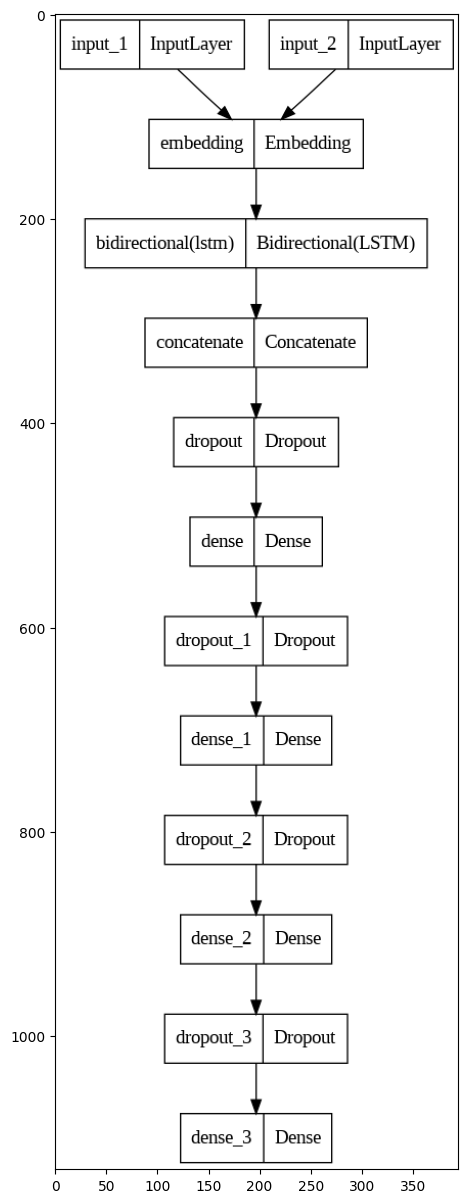

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [ ]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 27s 201ms/step - loss: 0.7209 - accuracy: 0.5374 - val_loss: 0.6693 - val_accuracy: 0.5869 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 15s 181ms/step - loss: 0.6420 - accuracy: 0.6363 - val_loss: 0.6149 - val_accuracy: 0.6576 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5996 - accuracy: 0.6739 - val_loss: 0.6023 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 184ms/step - loss: 0.5788 - accuracy: 0.6885 - val_loss: 0.5918 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 184ms/step - loss: 0.5609 - accuracy: 0.7033 - val_loss: 0.5647 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 187ms/step - loss: 0.5428 - accuracy: 0.7182 - val_loss: 0.5722 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 15s 182ms/st

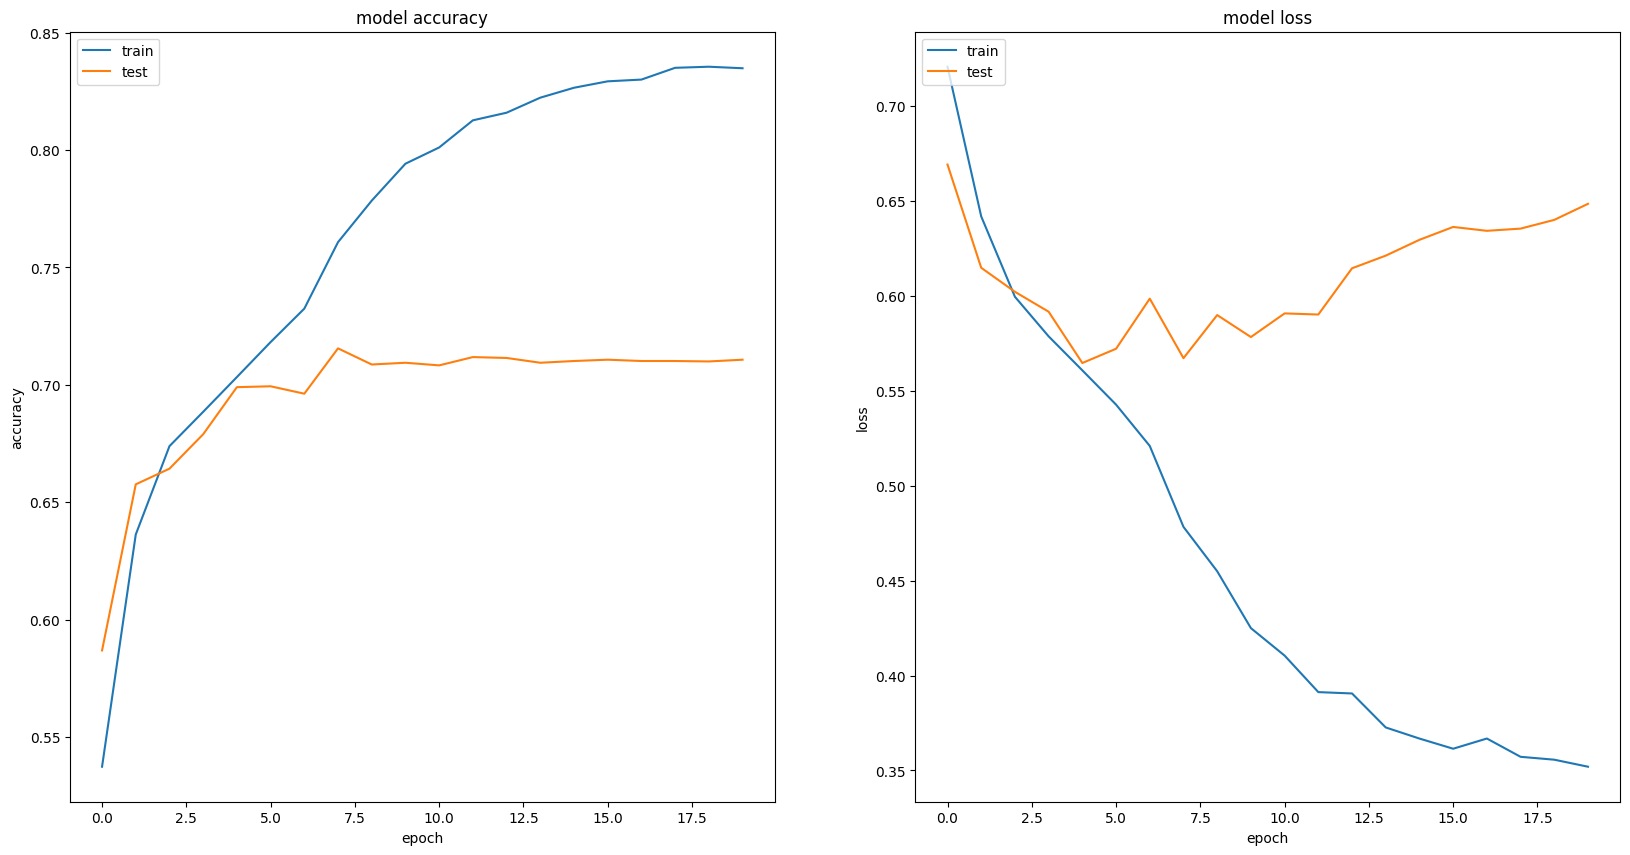

In [ ]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 6s 19ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.718124,0.715064,0.718426,0.718316,0.754744,0.716893,0.718124,0.734368,0.717066,0.717628,0.435316,0.623976


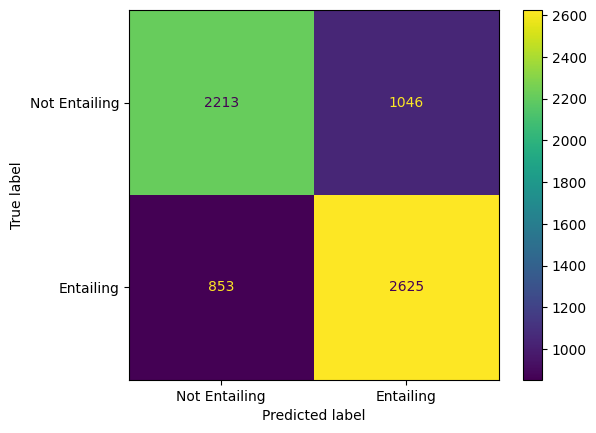

In [ ]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [ ]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,Computer Sciences Corporation (CSC) was an Ame...,Computer Sciences Corporation (CSC) was an Ame...,14.699636,1,0
1,Traditional examples of background music inclu...,Traditional examples of background music inclu...,12.298503,1,0
2,"However, we are so sophisticated psychometrica...",No research can be dissected by methodology al...,11.448615,0,1
3,He has collaborated on many occasions with Wyc...,He has collaborated on many occasions with Wyc...,10.934690,1,0
4,In the event that the selfinspection process d...,You are not required to consult with eh LSC if...,10.895027,0,1
5,my i've done that on occasion at at work and m...,My wife and I would like to gain full time emp...,10.848107,0,1
6,Combined Power Plant Air Pollutant Control,The power plant has water pollutant control.,9.764973,1,0
7,If Perot successfully woos Buchanan and Ventur...,None of the nominees from the Reform Party are...,9.486498,0,1
8,hell air pollution tends to be a a topic that ...,People should use less wood for their fireplaces.,9.010202,0,1
9,number one dental and medical yes,But dental doesn't count.,8.997474,0,1


# Experiment: Subtraction Sentence Fusion
Inspired by this paper & sentence fusion:
- https://ieeexplore.ieee.org/abstract/document/8029126

There appears to be 3 main ways to fuse sentences:
- Element-wise **subtraction**
- Element-wise **Multiplication**
- The two above but with **reversed** second sentences

Sentence fusion is where the two input sentences, of premises and hypotheses, are combined in different ways. Subtraction will subtract the hidden representations of either sequence. These representations are then passed through a further dense layer before the classifier layer. The 'fusion' layer refers to the dense layer afterwards.

This architecture experiments with just **subtraction**.

In [33]:
model_name = "model_subtraction_fusion"

## Model Architecture

In [36]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     3860352   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1024)                 5246976   ['embedding[0][0]',       

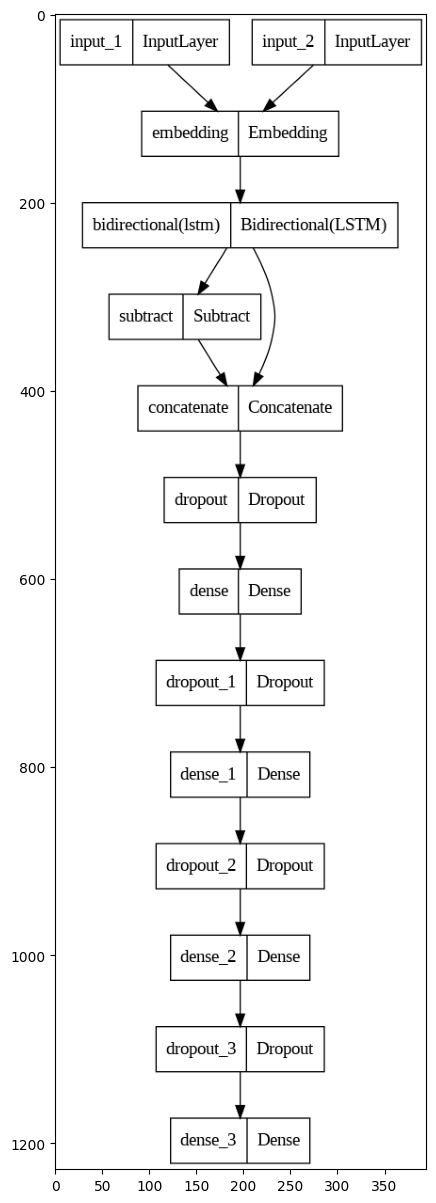

In [37]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

sub = subtract([premises, hypotheses])
merged = concatenate([premises, sub, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [39]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 30s 197ms/step - loss: 0.7055 - accuracy: 0.5678 - val_loss: 0.9676 - val_accuracy: 0.6237
Epoch 2/20
85/85 [==============================] - 15s 180ms/step - loss: 0.6204 - accuracy: 0.6582 - val_loss: 0.6002 - val_accuracy: 0.6743
Epoch 3/20
85/85 [==============================] - 15s 180ms/step - loss: 0.5928 - accuracy: 0.6799 - val_loss: 0.5831 - val_accuracy: 0.6849
Epoch 4/20
85/85 [==============================] - 15s 180ms/step - loss: 0.5697 - accuracy: 0.6990 - val_loss: 0.6339 - val_accuracy: 0.6903
Epoch 5/20
85/85 [==============================] - 16s 183ms/step - loss: 0.5500 - accuracy: 0.7108 - val_loss: 0.5544 - val_accuracy: 0.7096
Epoch 6/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5246 - accuracy: 0.7298 - val_loss: 0.5620 - val_accuracy: 0.7092
Epoch 7/20
85/85 [==============================] - 16s 183ms/step - loss: 0.5089 - accuracy: 0.7444 - val_loss: 0.6113 - val_accuracy: 0.7016

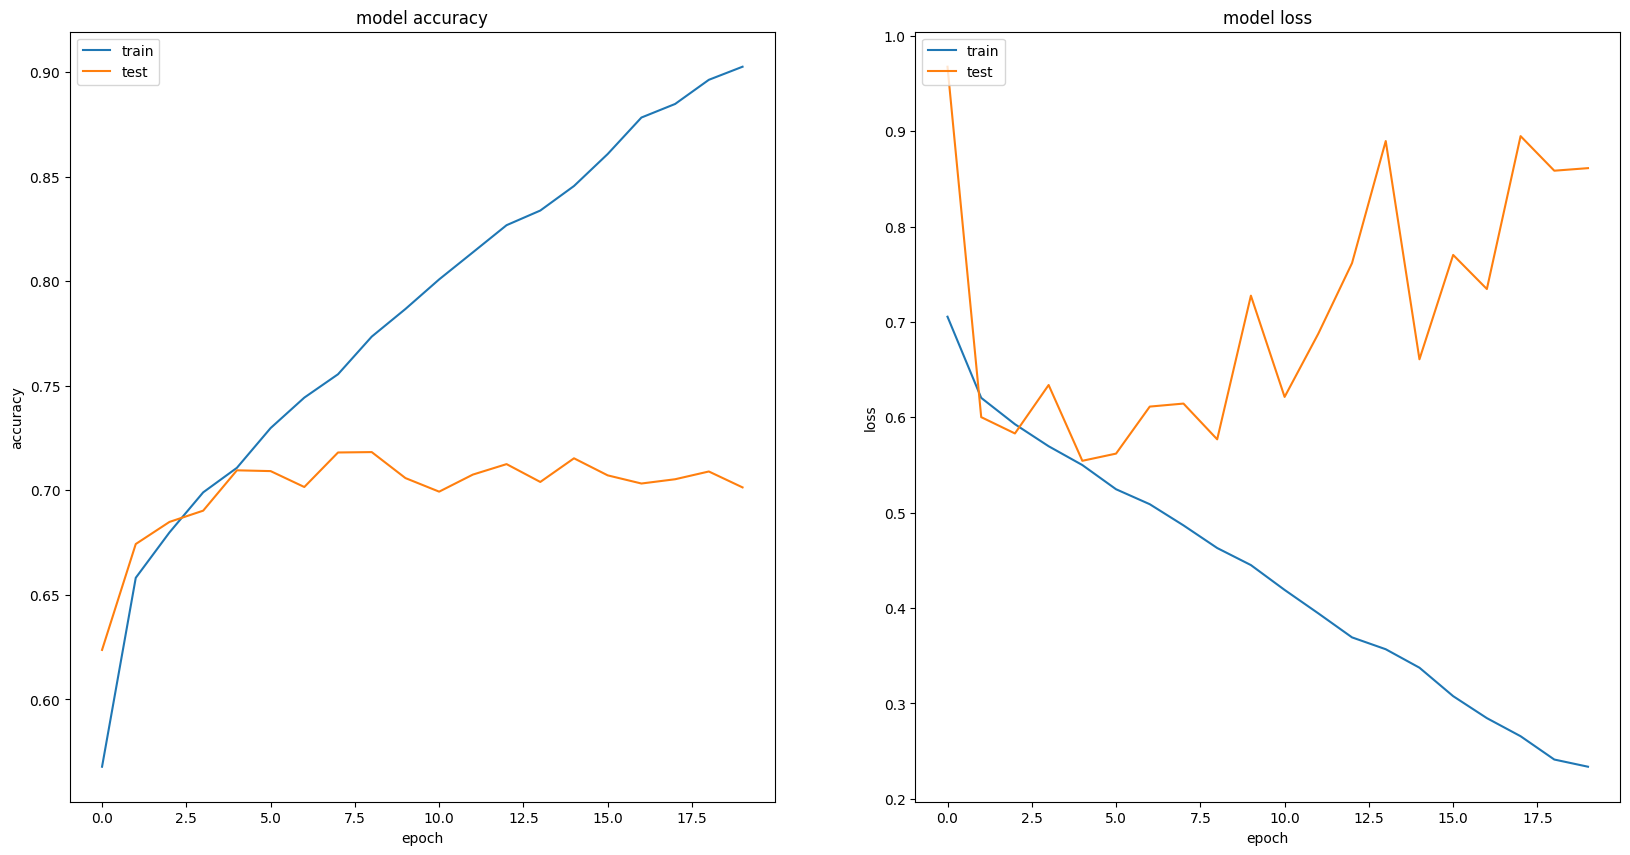

In [40]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [41]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [42]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.698531,0.688657,0.700118,0.699745,0.759344,0.696487,0.698531,0.722275,0.696311,0.697155,0.396588,0.832959


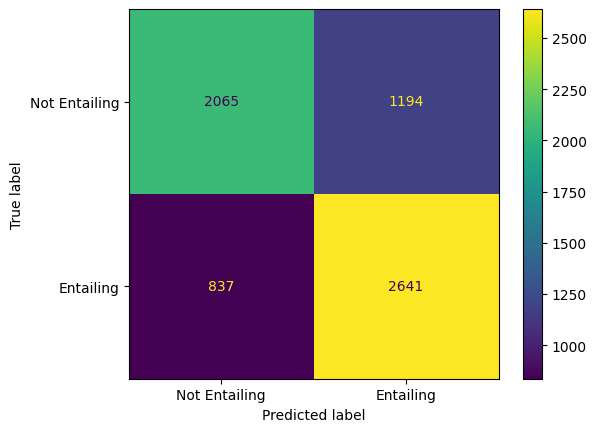

In [43]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [44]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,incredibly large sharks,The shark were way smaller than expected.,16.118095,1,0
1,my i've done that on occasion at at work and m...,My wife and I would like to gain full time emp...,16.118095,0,1
2,Good heavens! I said it quite quietly.,I couldn't speak up.,15.184237,0,1
3,"Yes, said Jon.",Jon denied this was true.,15.029717,1,0
4,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,14.829571,1,0
5,Computer Sciences Corporation (CSC) was an Ame...,Computer Sciences Corporation (CSC) was an Ame...,13.882884,1,0
6,"Copper and bronze were worked and re-exported,...","High quality foodstuffs like honey, oil, and w...",13.359445,1,0
7,The Initial Regulatory Flexibility Analysis di...,The Initial Regulatory Flexibility Analysis p...,13.252075,1,0
8,Excellent food and service.,The food was great.,13.009028,1,0
9,Small red airplane flies over mountaintop drop...,the plane is crashing,12.880754,1,0


# Experiment: Multiplication Sentence Fusion


In [ ]:
model_name = "model_multiplication_fusion"

## Model Architecture

In [ ]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_11 (Embedding)    multiple                     3860352   ['input_23[0][0]',            
                                                          0          'input_24[0][0]']            
                                                                                                  
 bidirectional_11 (Bidirect  (None, 1024)                 5246976   ['embedding_11[0][0]', 

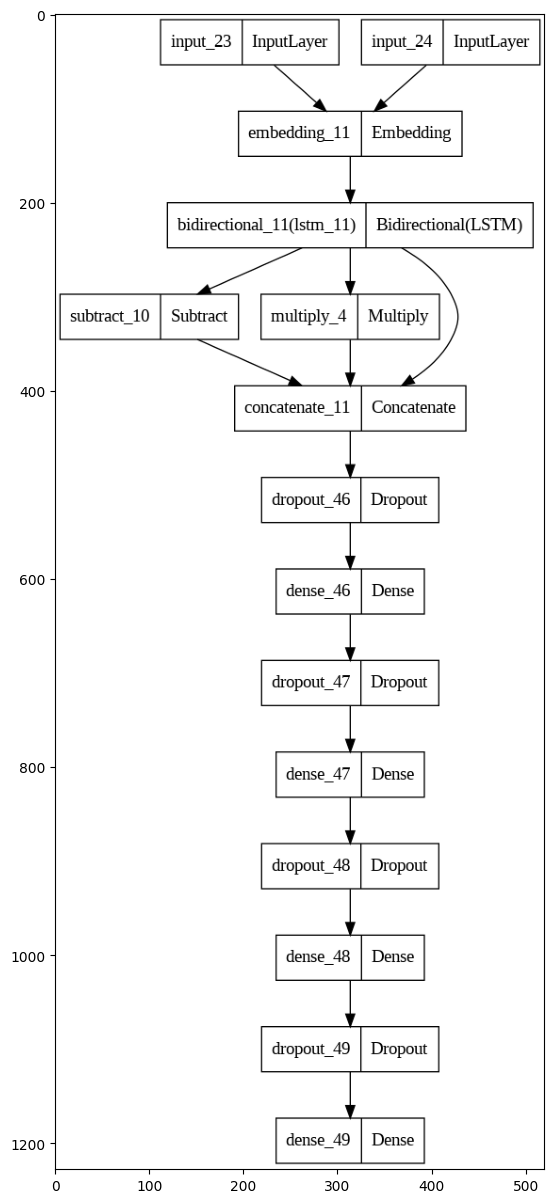

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

sub = subtract([premises, hypotheses])
mul = multiply([premises, hypotheses])
merged = concatenate([premises, hypotheses, sub, mul], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 25s 202ms/step - loss: 0.7159 - accuracy: 0.5630 - val_loss: 0.6239 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 185ms/step - loss: 0.6197 - accuracy: 0.6521 - val_loss: 0.6237 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 186ms/step - loss: 0.5899 - accuracy: 0.6791 - val_loss: 0.5954 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 185ms/step - loss: 0.5664 - accuracy: 0.6969 - val_loss: 0.5866 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 183ms/step - loss: 0.5486 - accuracy: 0.7099 - val_loss: 0.5852 - val_accuracy: 0.6996 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 183ms/step - loss: 0.5275 - accuracy: 0.7272 - val_loss: 0.5622 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 186ms/st

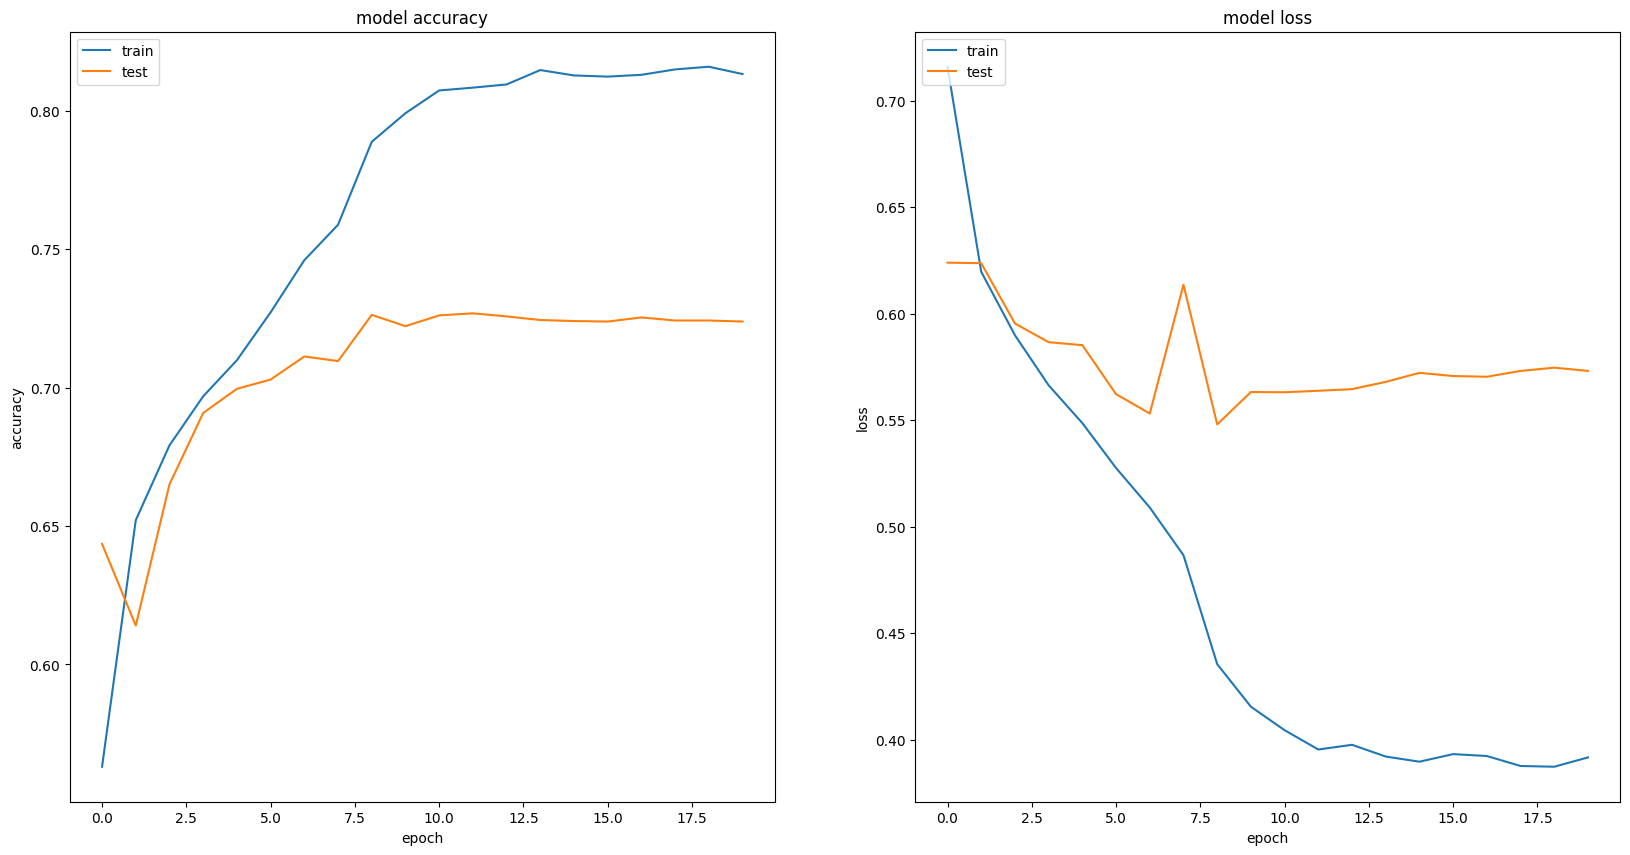

In [ ]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.727772,0.729737,0.727642,0.72771,0.750719,0.727001,0.727772,0.740079,0.72716,0.72758,0.454642,0.577079


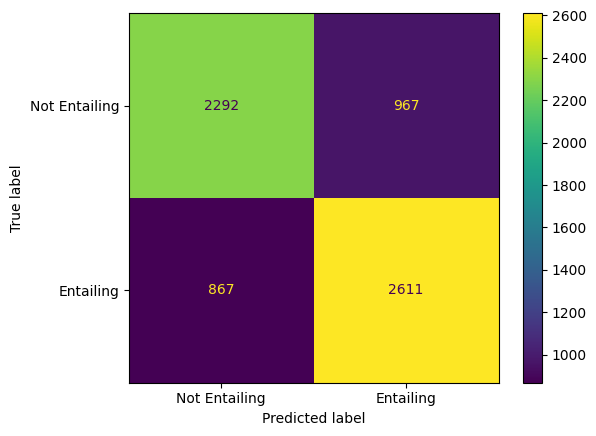

In [ ]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [ ]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

[3817 1210  438 1717 1833  926 4702 5529 3995 2072]


,Premise,Hypothesis,Loss,Predicted Label,True Label
0,Ionian Greeks from the island of Samos settled...,"The Ionian Greeks briefly explored Ephesus, bu...",13.222446,1,0
1,Traditional examples of background music inclu...,Traditional examples of background music inclu...,10.555787,1,0
2,Artists with the finest of brushes paint the m...,Religious paintings called thangkas are not ma...,9.827298,1,0
3,If Perot successfully woos Buchanan and Ventur...,None of the nominees from the Reform Party are...,9.325571,0,1
4,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,9.264121,1,0
5,Computer Sciences Corporation (CSC) was an Ame...,Computer Sciences Corporation (CSC) was an Ame...,8.674775,1,0
6,The week moved quickly.,They did not waste any time that week.,8.299080,0,1
7,Good heavens! I said it quite quietly.,I couldn't speak up.,7.946336,0,1
8,"We know this, because later she asked Dorcas t...",Dorcas did not bring any.,7.761622,0,1
9,number one dental and medical yes,But dental doesn't count.,7.703007,0,1


# Experiment: Attention


In [ ]:
model_name = "model_attention"

## Model Architecture

In [ ]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    multiple                     3860352   ['input_29[0][0]',            
                                                          0          'input_30[0][0]']            
                                                                                                  
 bidirectional_14 (Bidirect  (None, 1024)                 5246976   ['embedding_14[0][0]', 

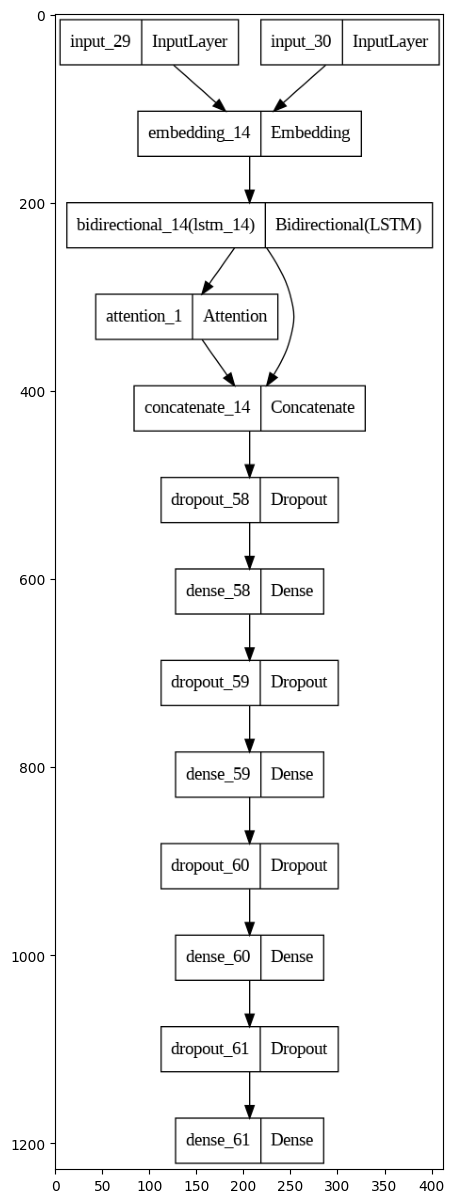

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

attention = Attention()([premises, hypotheses])
merged = concatenate([premises, attention, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 39s 210ms/step - loss: 0.7270 - accuracy: 0.5215 - val_loss: 0.6859 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 15s 182ms/step - loss: 0.6578 - accuracy: 0.6372 - val_loss: 0.6617 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 185ms/step - loss: 0.6068 - accuracy: 0.6700 - val_loss: 0.5884 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 185ms/step - loss: 0.5816 - accuracy: 0.6853 - val_loss: 0.6089 - val_accuracy: 0.6779 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 184ms/step - loss: 0.5625 - accuracy: 0.7018 - val_loss: 0.5691 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 186ms/step - loss: 0.5409 - accuracy: 0.7197 - val_loss: 0.5668 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 186ms/st

KeyboardInterrupt: 

In [ ]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

In [ ]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [ ]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

# Experiment: POS & NER Tags


In [101]:
model_name = "enhanced_embeddings"

## Model Architecture

In [102]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [103]:
POS_EMBEDDING_SIZE: int = 100
# NER_EMBEDDING_SIZE: int = 50

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                            

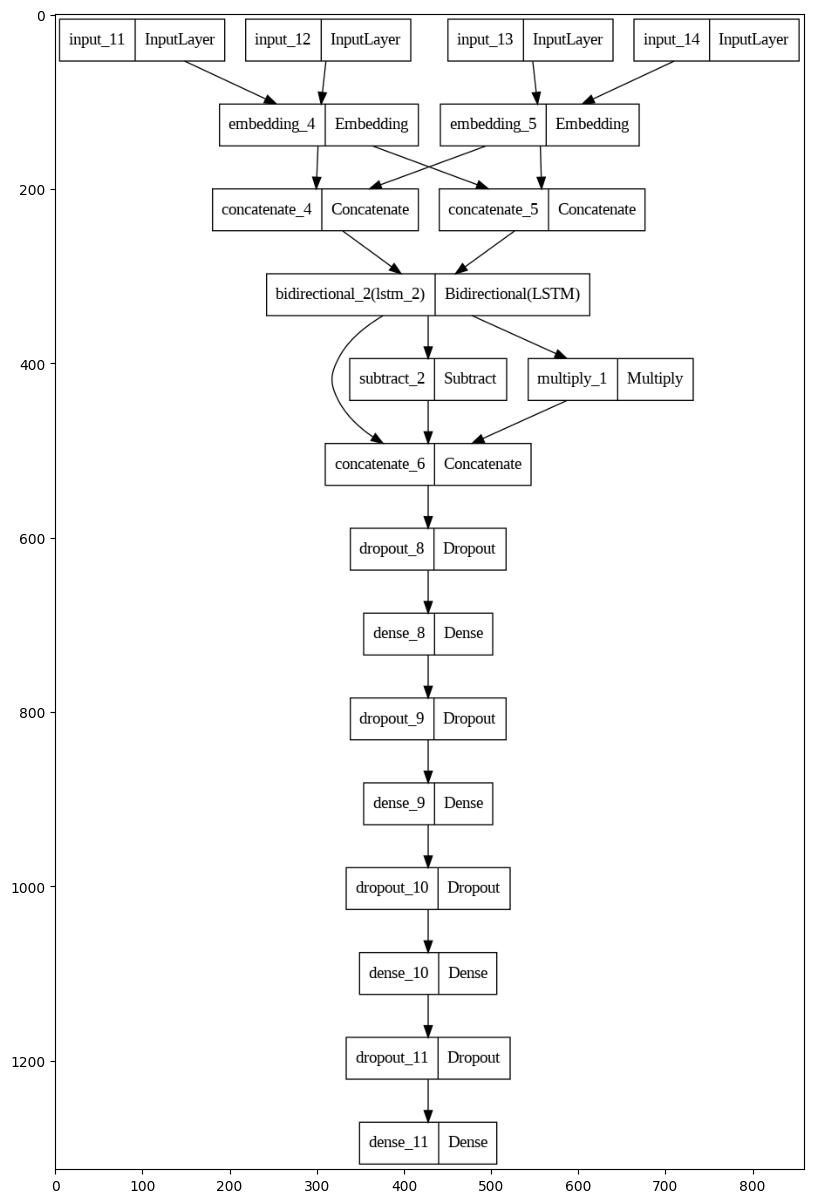

In [105]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

input_premises_pos = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses_pos = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

# input_premises_ner = Input(shape=(MAX_PREMISE_LENGTH,))
# input_hypotheses_ner = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
pos_embedding_layer = Embedding(input_dim=POS_VOCAB_SIZE, output_dim=POS_EMBEDDING_SIZE, trainable=True)
# ner_embedding_layer = Embedding(input_dim=NER_VOCAB_SIZE, output_dim=NER_EMBEDDING_SIZE, trainable=True)

premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

premises_pos = pos_embedding_layer(input_premises_pos)
hypotheses_pos = pos_embedding_layer(input_hypotheses_pos)

# premises_ner = ner_embedding_layer(input_premises_ner)
# hypotheses_ner = ner_embedding_layer(input_hypotheses_ner)

# premise_concat = concatenate([premises, premises_pos, premises_ner], axis=-1)
# hypothesis_concat = concatenate([hypotheses, hypotheses_pos, hypotheses_ner], axis=-1)
premise_concat = concatenate([premises, premises_pos], axis=-1)
hypothesis_concat = concatenate([hypotheses, hypotheses_pos], axis=-1)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premise_concat)
hypotheses = lstm_layer(hypothesis_concat)

sub = subtract([premises, hypotheses])
mul = multiply([premises, hypotheses])
merged = concatenate([premises, sub, mul, hypotheses], axis=-1)

x = Dropout(0.2)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

# model = Model(inputs=[input_premises, input_premises_pos, input_premises_ner, input_hypotheses, input_hypotheses_pos, input_hypotheses_ner], outputs=output_layer)
model = Model(inputs=[input_premises, input_premises_pos, input_hypotheses, input_hypotheses_pos], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [106]:
OPTIMIZER = RMSprop(INITIAL_LR)
EPOCHS = 50

In [107]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [108]:
# history = model.fit([train_premises, train_premises_pos, train_premises_ner, train_hypotheses, train_hypotheses_pos, train_hypotheses_ner], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks = [callback])
history = model.fit([train_premises, train_premises_pos, train_hypotheses, train_hypotheses_pos], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks = [callback])

Epoch 1/50
85/85 [==============================] - 30s 250ms/step - loss: 0.6908 - accuracy: 0.5854 - val_loss: 0.6297 - val_accuracy: 0.6446 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 17s 205ms/step - loss: 0.6118 - accuracy: 0.6618 - val_loss: 0.5974 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 17s 202ms/step - loss: 0.5828 - accuracy: 0.6860 - val_loss: 0.5921 - val_accuracy: 0.6886 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 17s 204ms/step - loss: 0.5581 - accuracy: 0.7065 - val_loss: 0.5581 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 18s 209ms/step - loss: 0.5340 - accuracy: 0.7276 - val_loss: 0.5997 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 18s 208ms/step - loss: 0.5108 - accuracy: 0.7414 - val_loss: 0.6289 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 17s 200ms/st

KeyboardInterrupt: 

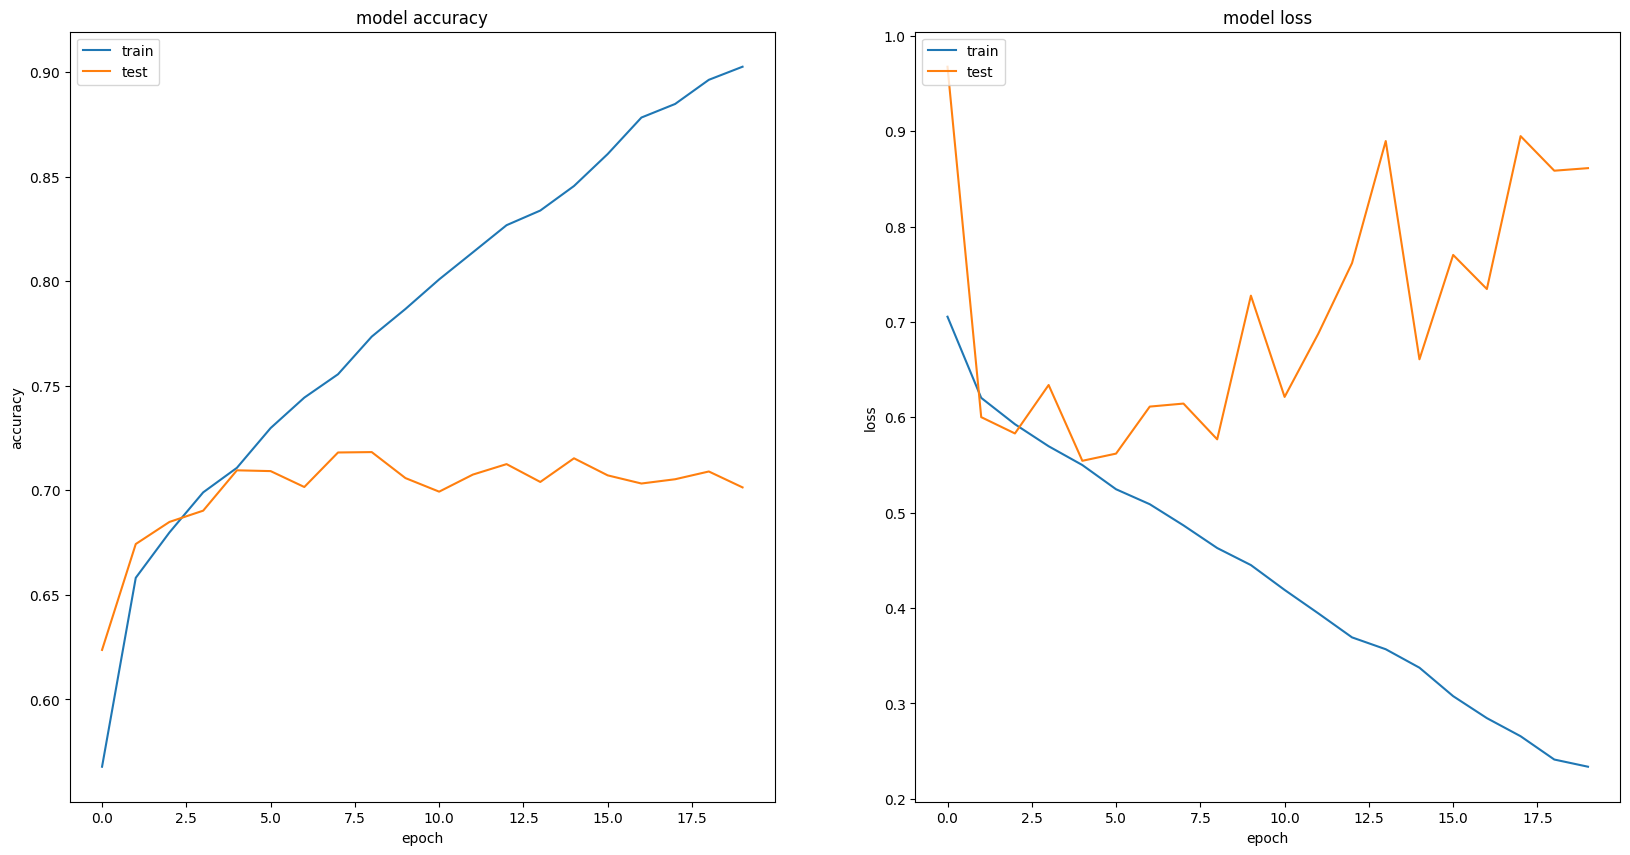

In [109]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [110]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [111]:
predicted_logits = model.predict(x=[dev_premises, dev_premises_pos, dev_hypotheses, dev_hypotheses_pos])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 16ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.719757,0.726496,0.719461,0.71969,0.73318,0.719306,0.719757,0.729823,0.719367,0.719707,0.438767,0.660131


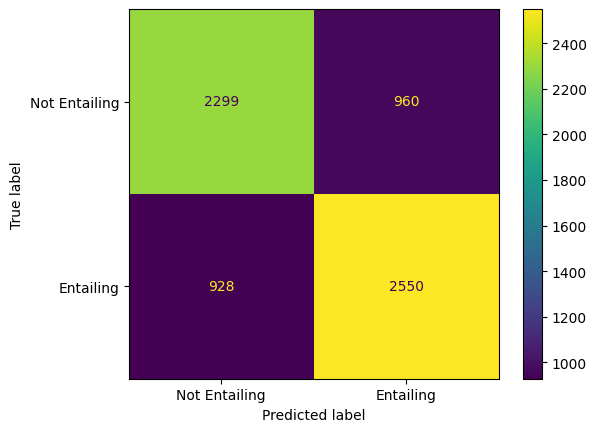

In [112]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [113]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,16.118095,1,0
1,Traditional examples of background music inclu...,Traditional examples of background music inclu...,15.205050,1,0
2,If Perot successfully woos Buchanan and Ventur...,None of the nominees from the Reform Party are...,12.238355,0,1
3,Ionian Greeks from the island of Samos settled...,"The Ionian Greeks briefly explored Ephesus, bu...",11.581439,1,0
4,away from the children,No adults allowed near the children,11.433804,0,1
5,The week moved quickly.,They did not waste any time that week.,11.332473,0,1
6,Artists with the finest of brushes paint the m...,Religious paintings called thangkas are not ma...,11.256065,1,0
7,Good heavens! I said it quite quietly.,I couldn't speak up.,11.197384,0,1
8,my i've done that on occasion at at work and m...,My wife and I would like to gain full time emp...,11.089325,0,1
9,number one dental and medical yes,But dental doesn't count.,11.047709,0,1


# Experiment: Premise/Hypothesis Pruning

In [149]:
def prune_sentences(premise, hypothesis):
  new_premise, new_hypothesis = [], []
  for i in range(max(len(premise), len(hypothesis))):
    if(i >= len(premise)):
      new_hypothesis.extend(hypothesis[i:])
      break
    elif(i >= len(hypothesis)):
      new_premise.extend(premise[i:])
      break
    if(premise[i] != hypothesis[i]):
      new_premise.append(premise[i])
      new_hypothesis.append(hypothesis[i])
  return (pad_lists(lists=[new_premise], value=0, length=MAX_PREMISE_LENGTH)[0], pad_lists(lists=[new_hypothesis], value=0, length=MAX_HYPOTHESIS_LENGTH)[0])

In [155]:
for i in range(len(dev_premises)):
  dev_premises[i], dev_hypotheses[i] = prune_sentences(dev_premises[i], dev_hypotheses[i])

for i in range(len(train_premises)):
  train_premises[i], train_hypotheses[i] = prune_sentences(train_premises[i], train_hypotheses[i])

In [156]:
model_name = "word_pruning"

## Model Architecture

In [157]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     multiple                     3860352   ['input_15[0][0]',            
                                                          0          'input_16[0][0]']            
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 1024)                 5246976   ['embedding_6[0][0]',   

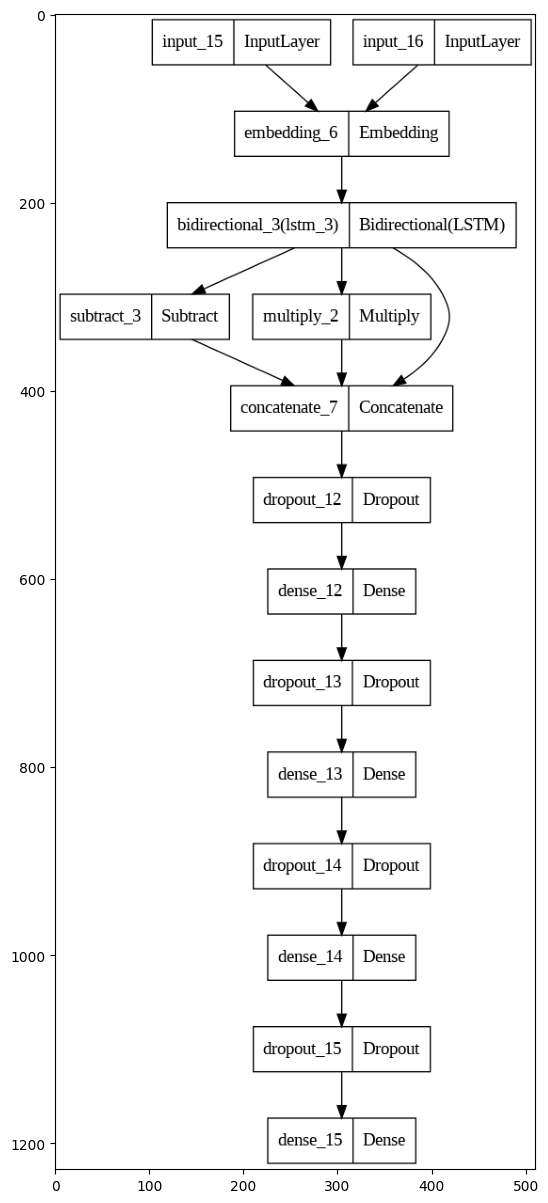

In [158]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

sub = subtract([premises, hypotheses])
mul = multiply([premises, hypotheses])
merged = concatenate([premises, hypotheses, sub, mul], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [159]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/50
85/85 [==============================] - 23s 199ms/step - loss: 0.6764 - accuracy: 0.6001 - val_loss: 0.6469 - val_accuracy: 0.5931 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 16s 190ms/step - loss: 0.6003 - accuracy: 0.6702 - val_loss: 0.5950 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 15s 180ms/step - loss: 0.5647 - accuracy: 0.6991 - val_loss: 0.5967 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 16s 183ms/step - loss: 0.5372 - accuracy: 0.7211 - val_loss: 0.6567 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 15s 181ms/step - loss: 0.4953 - accuracy: 0.7517 - val_loss: 0.5480 - val_accuracy: 0.7265 - lr: 1.0000e-04
Epoch 6/50
85/85 [==============================] - 16s 183ms/step - loss: 0.4769 - accuracy: 0.7607 - val_loss: 0.5483 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 7/50
85/85 [==============================] - 16s 

KeyboardInterrupt: 

In [ ]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [160]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 16ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.724061,0.714778,0.725314,0.724971,0.774583,0.722364,0.724061,0.74348,0.722471,0.723154,0.447668,0.548801


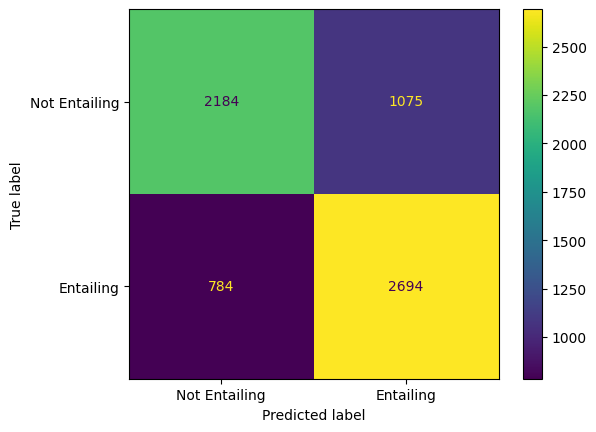

In [161]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [162]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,16.118095,1,0
1,You can give me milk and spinach.,You will give me milk and spinach or else.,10.036768,1,0
2,This school district is composed of six school...,This school district is composed of six school...,9.303101,1,0
3,The Jazz also beat the Los Angeles Lakers ' re...,The Jazz also beat the Los Angeles Lakers' rec...,9.211923,1,0
4,They went back and forth for some time.,They had all made their decision except one an...,7.121275,1,0
5,If Perot successfully woos Buchanan and Ventur...,None of the nominees from the Reform Party are...,6.885800,0,1
6,"We know this, because later she asked Dorcas t...",Dorcas did not bring any.,6.125435,0,1
7,okay well what are we doing about recycling in...,Our community does not recycle.,5.943374,0,1
8,The devastating military expedition he launche...,The wars and military endeavors caused him to ...,5.666637,1,0
9,Air Power Australia is not affiliated with the...,Air Power Australia is not affiliated with the...,5.350945,0,1
